In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os

from utils.plotter import Plotter
from utils.data_handler import DataHandler
from utils import get_diagnostics, get_rmses

identifier = "wind"
ts = ("2014-06-01", "2014-06-15")
data_folder = "data"
output_folder = f"output_2014_{identifier}"
his_file = "gtsm_fine_0000_his.nc"
stations_file = "locs.xyn"
tide_files = pd.read_csv(os.path.join(data_folder, "filenames.csv")).to_numpy().squeeze().tolist()
spin_up_steps = 1008  # Original estimation 914

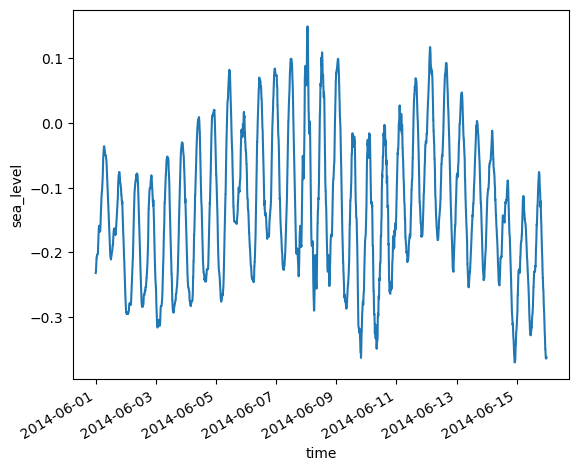

In [2]:
observations_sets = []
for file in tide_files:
    d = xr.load_dataset(os.path.join(data_folder, f"{file}.nc"))
    observations_sets.append(d)

observations_sets[2].sel(time=slice(*ts)).sea_level.plot()

In [3]:
for i, obs_set in enumerate(observations_sets):
    observations_sets[i] = obs_set.sel(time=slice(*ts))

In [4]:
his = xr.load_dataset(os.path.join(output_folder, his_file))

In [5]:
his = xr.load_dataset(os.path.join(output_folder, his_file))
his["station_name"] = his.station_name.astype("U")
his = his.assign_coords(
    station_name=np.array(list(map(lambda x: x.strip(), his.station_name.to_numpy())))
)
his = his.swap_dims({"station_name": "stations"})
his

<xarray.Dataset>
Dimensions:                                  (stations: 4159,
                                              station_geom_nNodes: 4159,
                                              time: 2511)
Coordinates:
    station_x_coordinate                     (stations) float64 3.81 ... -101.6
    station_y_coordinate                     (stations) float64 55.4 ... 17.64
    station_name                             (stations) <U82 'GESLA3-a121-a12...
  * time                                     (time) datetime64[ns] 2014-05-25...
Dimensions without coordinates: stations, station_geom_nNodes
Data variables: (12/57)
    wgs84                                    int32 -2147483647
    station_id                               (stations) |S256 b'GESLA3-a121-a...
    station_geom                             int32 -2147483647
    station_geom_node_count                  (stations) int32 1 1 1 1 ... 1 1 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 3....
    station_geom_node_coordy                 (station_geom_nNodes) float64 55...
    ...                                       ...
    water_balance_Qext_out_2D                (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_Qext_total_2D              (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_total_volume_interception  (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_evaporation_interception   (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_precipitation_on_ground    (time) float64 0.0 0.0 ... 0.0 0.0
    timestep                                 (time) float64 10.0 93.75 ... 150.0
Attributes:
    institution:               Deltares
    references:                http://www.deltares.nl
    source:                    Deltares, D-Flow FM Version 1.2.177.142431, Ja...
    history:                   Created on 2023-08-16T18:23:51+0200, D-Flow FM
    date_created:              2023-08-16T18:23:51+0200
    date_modified:             2023-08-16T18:23:51+0200
    Conventions:               CF-1.5 Deltares-0.1 ACDD-1.3
    uuid:                      b0f6351e-d148-42e7-9f47-d6744f8c8fe1
    time_coverage_start:       2014-05-25T**:00:00+00:00
    time_coverage_end:         2014-06-16T**:00:00+00:00
    time_coverage_duration:    P0000-00-22T00:00:00
    time_coverage_resolution:  P0000-00-00T00:10:00

In [6]:
station_names = [f"GESLA3-{name}" for name in tide_files]
his = his.set_index(stations="station_name")
his = his.sel(stations=station_names)
his = DataHandler.clip_dataset(spin_up_steps, his)
his

<xarray.Dataset>
Dimensions:                                  (stations: 10,
                                              station_geom_nNodes: 4159,
                                              time: 1503)
Coordinates:
    station_x_coordinate                     (stations) float64 6.828 ... 22.13
    station_y_coordinate                     (stations) float64 53.45 ... -34.18
  * time                                     (time) datetime64[ns] 2014-06-01...
  * stations                                 (stations) <U82 'GESLA3-eemshave...
Dimensions without coordinates: station_geom_nNodes
Data variables: (12/57)
    wgs84                                    int32 -2147483647
    station_id                               (stations) |S256 b'GESLA3-eemsha...
    station_geom                             int32 -2147483647
    station_geom_node_count                  (stations) int32 1 1 1 1 ... 1 1 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 3....
    station_geom_node_coordy                 (station_geom_nNodes) float64 55...
    ...                                       ...
    water_balance_Qext_out_2D                (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_Qext_total_2D              (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_total_volume_interception  (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_evaporation_interception   (time) float64 0.0 0.0 ... 0.0 0.0
    water_balance_precipitation_on_ground    (time) float64 0.0 0.0 ... 0.0 0.0
    timestep                                 (time) float64 150.0 ... 150.0
Attributes:
    institution:               Deltares
    references:                http://www.deltares.nl
    source:                    Deltares, D-Flow FM Version 1.2.177.142431, Ja...
    history:                   Created on 2023-08-16T18:23:51+0200, D-Flow FM
    date_created:              2023-08-16T18:23:51+0200
    date_modified:             2023-08-16T18:23:51+0200
    Conventions:               CF-1.5 Deltares-0.1 ACDD-1.3
    uuid:                      b0f6351e-d148-42e7-9f47-d6744f8c8fe1
    time_coverage_start:       2014-05-25T**:00:00+00:00
    time_coverage_end:         2014-06-16T**:00:00+00:00
    time_coverage_duration:    P0000-00-22T00:00:00
    time_coverage_resolution:  P0000-00-00T00:10:00

In [16]:
ts_sim.sel(time=ts_obs.sel(time=slice(None, "2014-06-10")))

<xarray.DataArray 'time' (time: 240)>
array(['2014-06-01T00:00:00.000000000', '2014-06-01T01:00:00.000000000',
       '2014-06-01T02:00:00.000000000', ..., '2014-06-10T21:00:00.000000000',
       '2014-06-10T22:00:00.000000000', '2014-06-10T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-06-01 ... 2014-06-10T23:00:00
Attributes:
    standard_name:  time

<Figure size 640x480 with 0 Axes>

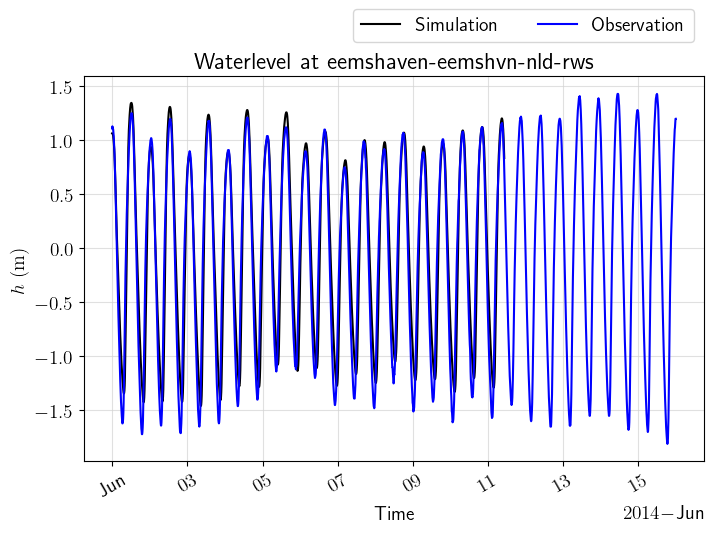

<Figure size 640x480 with 0 Axes>

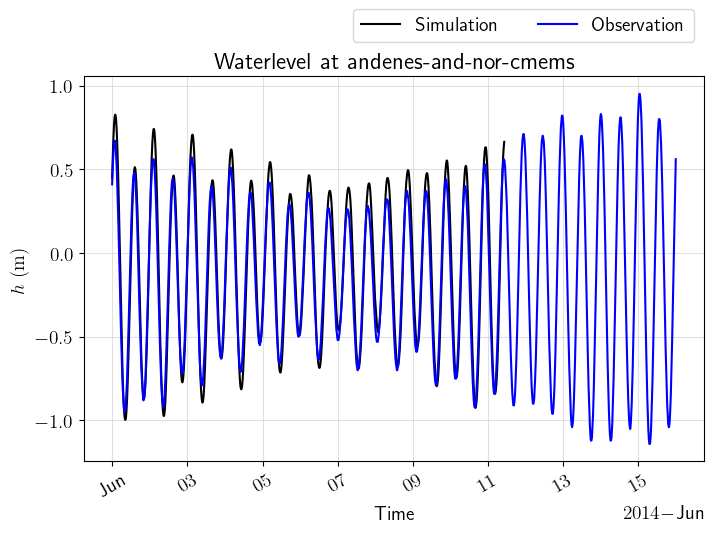

<Figure size 640x480 with 0 Axes>

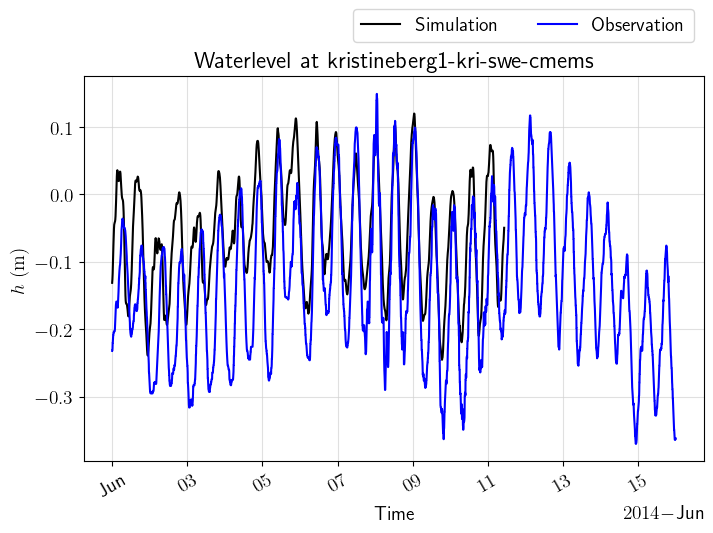

<Figure size 640x480 with 0 Axes>

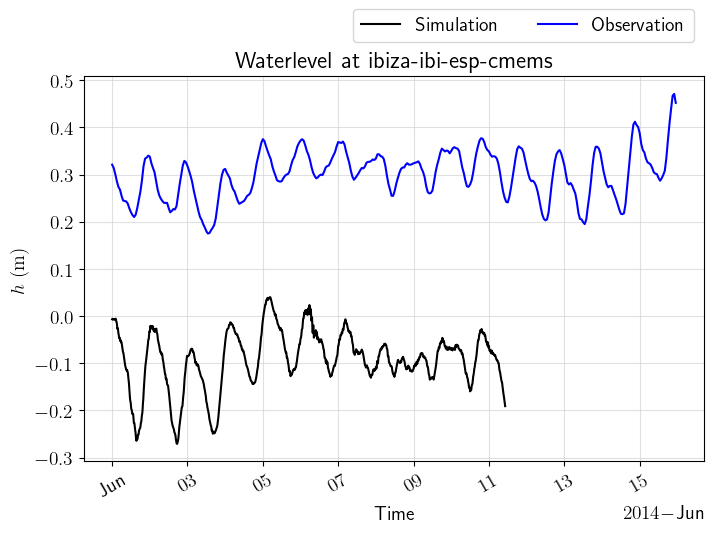

<Figure size 640x480 with 0 Axes>

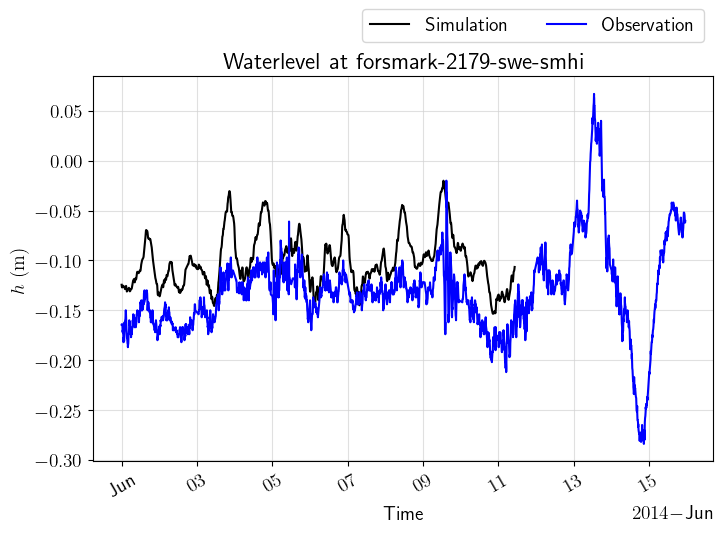

<Figure size 640x480 with 0 Axes>

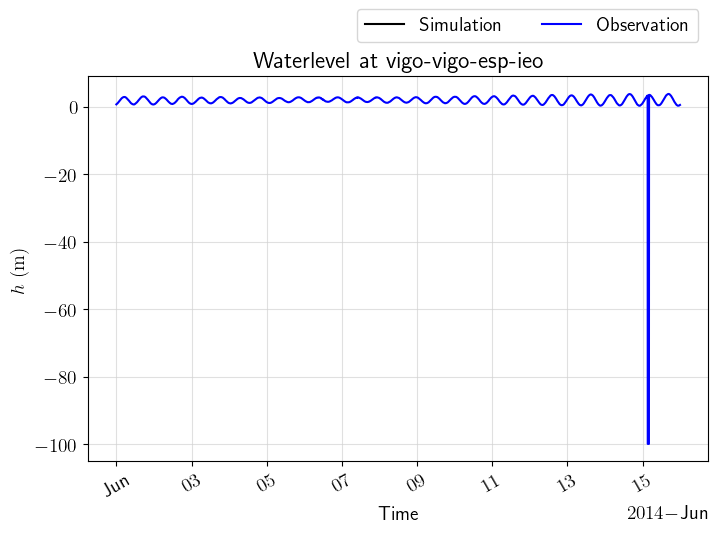

<Figure size 640x480 with 0 Axes>

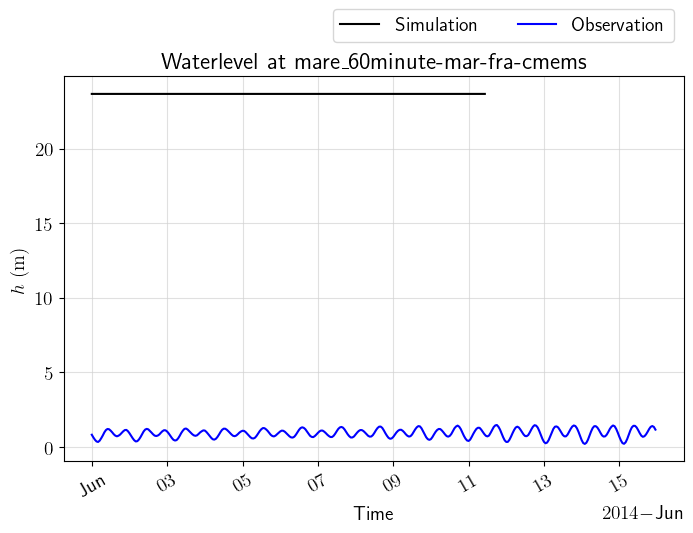

<Figure size 640x480 with 0 Axes>

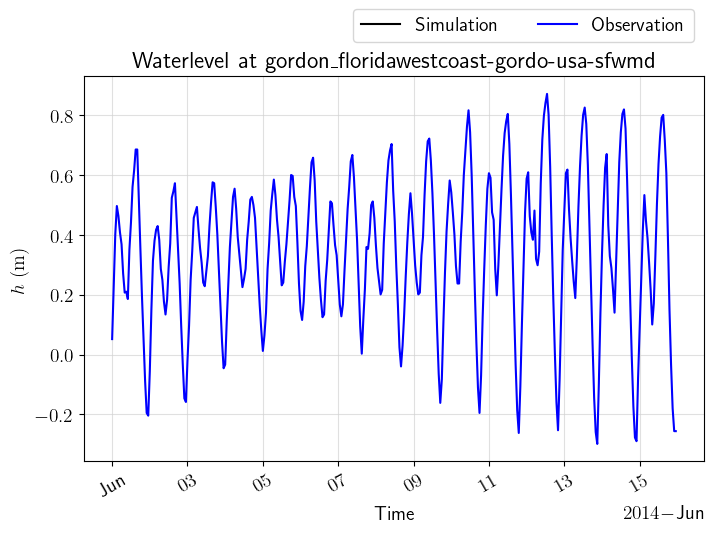

<Figure size 640x480 with 0 Axes>

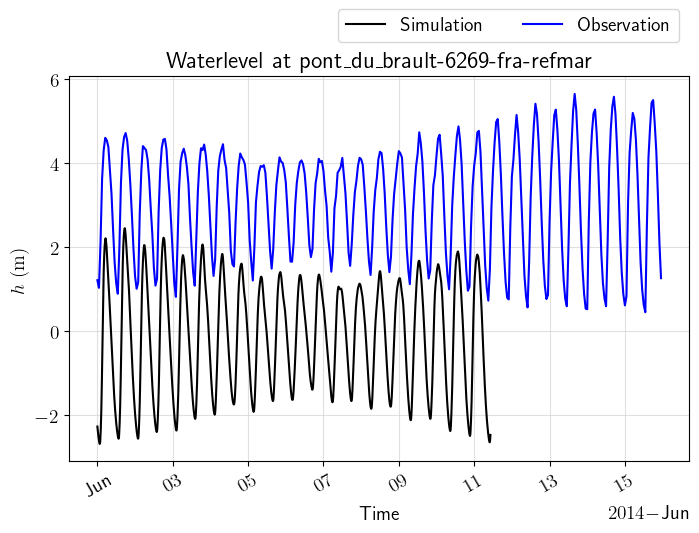

<Figure size 640x480 with 0 Axes>

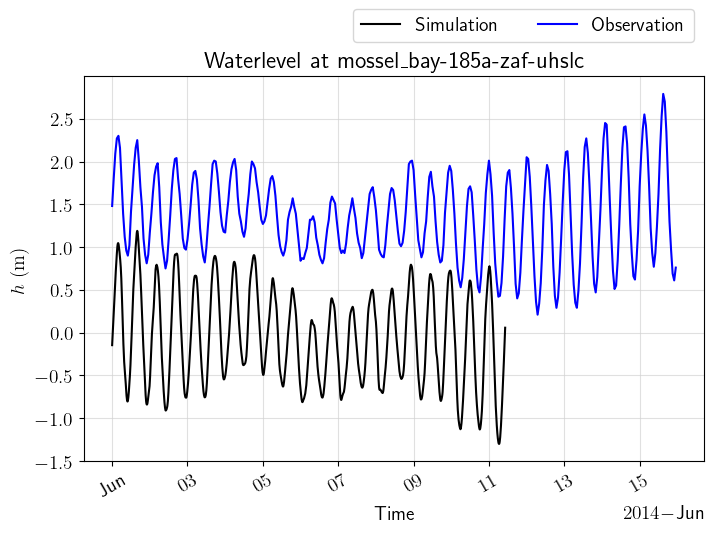

In [8]:
title_func = lambda s: f"Waterlevel at {s}"
ts_sim = his.time
for i, name in enumerate(tide_files):
    obs = observations_sets[i]
    ts_obs = obs.time
    data_obs = obs.sea_level
    data_sim = his.isel(stations=i).waterlevel
    Plotter.plot_series(
        [ts_sim, ts_obs],
        [data_sim, data_obs],
        name,
        title_func,
        legends=["Simulation", "Observation"],
        save=True,
        identifier=identifier,
    )
    # plt.show()

In [28]:
(ts_obs.values[1] - ts_obs.values[0]) / np.timedelta64(1, "s")

3600.0

<Figure size 640x480 with 0 Axes>

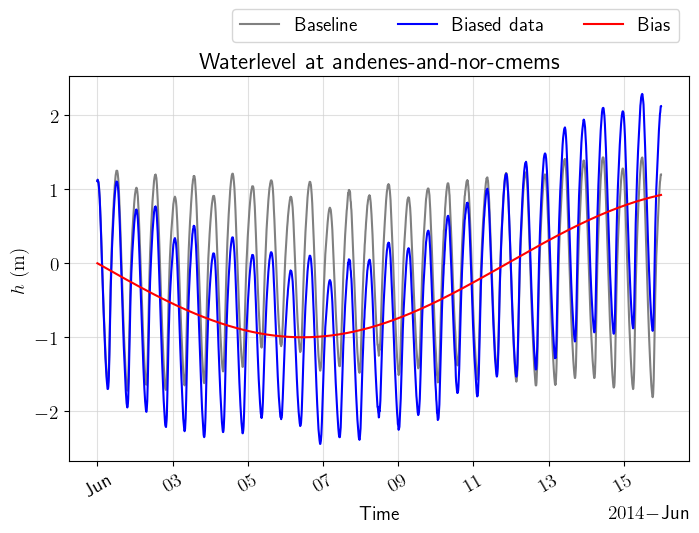

In [40]:
title_func = lambda s: f"Waterlevel at {s}"
ts_sim = his.time
for i, name in enumerate([tide_files[1]]):
    obs = observations_sets[i]
    ts_obs = obs.time
    data_obs = obs.sea_level
    bias = lambda t: np.sin((t - ts_obs.values[0]) / np.timedelta64(1, "s") / 300000)

    ws = data_obs - bias(ts_obs.values)
    Plotter.plot_series(
        [ts_obs, ts_obs, ts_obs],
        [data_obs, ws, -bias(ts_obs)],
        name,
        title_func,
        save=True,
        legends=["Baseline", "Biased data", "Bias"],
        identifier=identifier,
    )
    plt.show()